In [1]:
import os 
import pandas as pd 
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import glob
import matplotlib.pyplot as plt

import requests
import zipfile
import pathlib
from pathlib import Path

from tqdm import tqdm # progress bar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

# Importation des données


In [2]:
if not Path('../model').exists():
    Path('../model').mkdir()

In [3]:
zipfile.ZipFile("../data/archive.zip").extractall("../data/urbansound8k") # extrait le fichier zip dans le dossier data

In [4]:
songs = Path("../data/urbansound8k").rglob("*.wav")
print(type(songs))
songs = [*songs] # lecture du generator et stockage dans une liste
print(type(songs))

print(f"Il y a {len(songs)} fichiers wav.")
songs[:3] # affichage des 3 permiers éléments

<class 'generator'>
<class 'list'>
Il y a 8732 fichiers wav.


[WindowsPath('../data/urbansound8k/fold1/101415-3-0-2.wav'),
 WindowsPath('../data/urbansound8k/fold1/101415-3-0-3.wav'),
 WindowsPath('../data/urbansound8k/fold1/101415-3-0-8.wav')]

In [5]:
liste_id_songs = [path.name for path in songs]
liste_id_songs[:3]

['101415-3-0-2.wav', '101415-3-0-3.wav', '101415-3-0-8.wav']

In [6]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    return mfccsscaled

In [7]:
df_features = pd.DataFrame()

liste_id_songs = list()

for file_path in tqdm(songs):
    data = extract_features(file_path)
    row = pd.Series(data)
    liste_id_songs.append(file_path.name)
    df_features = df_features.append(row, ignore_index=True)

100%|██████████| 8732/8732 [06:38<00:00, 21.89it/s]


In [8]:
liste_id_songs[0]

'101415-3-0-2.wav'

In [9]:
labels = pd.read_csv("../data/urbansound8k/UrbanSound8K.csv")
labels.head()
labels.shape 

(8732, 8)

In [10]:
classes = set(labels['class'])
classes = list(sorted(classes))
classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [11]:
labels = labels[['slice_file_name','class']]
labels = labels.set_index('slice_file_name')

In [12]:
labels.head()

,class
slice_file_name,
100032-3-0-0.wav,dog_bark
100263-2-0-117.wav,children_playing
100263-2-0-121.wav,children_playing
100263-2-0-126.wav,children_playing
100263-2-0-137.wav,children_playing


<AxesSubplot:title={'center':'nombre de fichiers audio par classes'}, xlabel='class'>

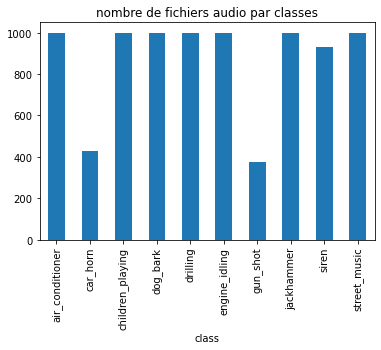

In [13]:
labels.groupby('class').size().plot.bar(title="nombre de fichiers audio par classes")

In [14]:
df_features["name"] = pd.Series(liste_id_songs)

In [15]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,name
0,-403.967621,94.398071,17.751820,-11.521064,-7.489263,4.073067,-16.308868,-6.735374,-10.601528,-5.113414,...,-1.034300,-2.655814,-0.523793,-2.002407,-2.941532,-3.149520,-1.447502,-2.512676,-2.795815,101415-3-0-2.wav
1,-368.110046,128.744812,28.912741,-21.190054,-15.262681,2.639470,-28.895718,-17.582800,-23.663269,-8.707304,...,-2.410350,-2.949749,1.217798,0.048635,-1.981228,-1.498706,0.567786,-2.555046,-5.152623,101415-3-0-3.wav
2,-422.479034,70.383469,9.934862,0.000618,1.643423,3.714230,-9.649158,-1.782196,-3.811726,-0.288196,...,-1.916761,-3.216991,-1.455734,-1.007524,-2.732134,-2.439353,-0.801251,-2.324180,-1.682428,101415-3-0-8.wav
3,-260.239990,109.351807,-51.811283,-4.287414,-18.306389,2.771631,-6.817822,7.485249,0.031476,12.308299,...,-2.872584,-1.553901,0.787444,-2.719564,0.414522,-2.019426,0.775039,1.656904,-0.095491,102106-3-0-0.wav
4,-386.784851,132.629608,25.220676,22.799538,-10.436672,4.516113,-6.532164,9.258158,-0.426317,7.659397,...,0.536787,0.977274,0.158055,-0.349544,-0.285354,-0.686473,0.383958,0.610550,1.072113,102305-6-0-0.wav


# Préparation du dataset

In [16]:
merged_dataframe = pd.merge(left=df_features, right=labels, left_on='name', right_on='slice_file_name')

In [17]:
merged_dataframe.head() 

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,name,class
0,-403.967621,94.398071,17.751820,-11.521064,-7.489263,4.073067,-16.308868,-6.735374,-10.601528,-5.113414,...,-2.655814,-0.523793,-2.002407,-2.941532,-3.149520,-1.447502,-2.512676,-2.795815,101415-3-0-2.wav,dog_bark
1,-368.110046,128.744812,28.912741,-21.190054,-15.262681,2.639470,-28.895718,-17.582800,-23.663269,-8.707304,...,-2.949749,1.217798,0.048635,-1.981228,-1.498706,0.567786,-2.555046,-5.152623,101415-3-0-3.wav,dog_bark
2,-422.479034,70.383469,9.934862,0.000618,1.643423,3.714230,-9.649158,-1.782196,-3.811726,-0.288196,...,-3.216991,-1.455734,-1.007524,-2.732134,-2.439353,-0.801251,-2.324180,-1.682428,101415-3-0-8.wav,dog_bark
3,-260.239990,109.351807,-51.811283,-4.287414,-18.306389,2.771631,-6.817822,7.485249,0.031476,12.308299,...,-1.553901,0.787444,-2.719564,0.414522,-2.019426,0.775039,1.656904,-0.095491,102106-3-0-0.wav,dog_bark
4,-386.784851,132.629608,25.220676,22.799538,-10.436672,4.516113,-6.532164,9.258158,-0.426317,7.659397,...,0.977274,0.158055,-0.349544,-0.285354,-0.686473,0.383958,0.610550,1.072113,102305-6-0-0.wav,gun_shot


In [18]:
merged_dataframe["y"] = LabelEncoder().fit_transform(merged_dataframe['class']) # The label encoder always sort the class so the mapping is always the same
merged_dataframe

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,name,class,y
0,-403.967621,94.398071,17.751820,-11.521064,-7.489263,4.073067,-16.308868,-6.735374,-10.601528,-5.113414,...,-0.523793,-2.002407,-2.941532,-3.149520,-1.447502,-2.512676,-2.795815,101415-3-0-2.wav,dog_bark,3
1,-368.110046,128.744812,28.912741,-21.190054,-15.262681,2.639470,-28.895718,-17.582800,-23.663269,-8.707304,...,1.217798,0.048635,-1.981228,-1.498706,0.567786,-2.555046,-5.152623,101415-3-0-3.wav,dog_bark,3
2,-422.479034,70.383469,9.934862,0.000618,1.643423,3.714230,-9.649158,-1.782196,-3.811726,-0.288196,...,-1.455734,-1.007524,-2.732134,-2.439353,-0.801251,-2.324180,-1.682428,101415-3-0-8.wav,dog_bark,3
3,-260.239990,109.351807,-51.811283,-4.287414,-18.306389,2.771631,-6.817822,7.485249,0.031476,12.308299,...,0.787444,-2.719564,0.414522,-2.019426,0.775039,1.656904,-0.095491,102106-3-0-0.wav,dog_bark,3
4,-386.784851,132.629608,25.220676,22.799538,-10.436672,4.516113,-6.532164,9.258158,-0.426317,7.659397,...,0.158055,-0.349544,-0.285354,-0.686473,0.383958,0.610550,1.072113,102305-6-0-0.wav,gun_shot,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-355.596924,105.955048,-48.766628,57.914871,-4.303929,19.364935,2.594625,10.438691,4.662246,10.513984,...,-0.979985,-1.907905,2.495256,0.844629,0.017631,-1.676227,0.225263,99500-2-0-23.wav,children_playing,2
8728,-372.619904,120.041092,-52.157391,52.686016,2.468143,30.225056,3.270729,5.431655,0.141910,16.509537,...,-1.131930,-2.051791,-1.799522,-0.874247,0.598182,-1.684182,0.555801,99500-2-0-29.wav,children_playing,2
8729,-342.279907,113.442352,-62.702427,62.841831,-5.029973,24.582609,1.372840,1.644158,2.130837,7.627467,...,-0.151377,-2.021508,0.718946,-0.702763,-1.490733,-0.708686,-2.425671,99500-2-0-39.wav,children_playing,2
8730,-351.106049,114.208069,-57.208488,63.083256,-5.599070,24.483217,2.186491,7.885724,4.597743,14.235478,...,1.603643,0.195600,1.322528,0.275680,-0.214784,-0.748009,-0.618953,99500-2-0-41.wav,children_playing,2


In [19]:
LabelEncoder().fit_transform(merged_dataframe['class'])

array([3, 3, 3, ..., 2, 2, 2])

In [20]:
x = merged_dataframe.iloc[:, :40]
y = merged_dataframe["y"]
file_name = merged_dataframe["name"]

## Split train test

In [21]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=random_state)
train_file_name, test_file_name = train_test_split(file_name, test_size=0.4, random_state=random_state) 

In [22]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
y_train

(5239, 40) (5239,) (3493, 40) (3493,)


6721    0
8367    9
7414    0
1496    5
8670    0
       ..
5734    1
5191    3
5390    2
860     7
7270    8
Name: y, Length: 5239, dtype: int32

In [23]:
print(train_file_name)
print(test_file_name)

6721     189981-0-0-8.wav
8367    185374-9-0-30.wav
7414     162103-0-0-4.wav
1496      39847-5-0-4.wav
8670      79089-0-0-4.wav
              ...        
5734     162702-1-1-0.wav
5191     34771-3-0-14.wav
5390      80806-2-0-2.wav
860       98223-7-3-0.wav
7270     133473-8-0-1.wav
Name: name, Length: 5239, dtype: object
6770    201988-5-0-21.wav
3534     110621-7-0-1.wav
8556      58937-4-0-0.wav
7870     76266-2-0-55.wav
1226     171478-9-0-4.wav
              ...        
3357     62837-7-1-80.wav
912     102857-5-0-27.wav
721       55020-4-0-7.wav
4057    195969-0-0-20.wav
8681     79089-0-0-70.wav
Name: name, Length: 3493, dtype: object


In [24]:
y_train

6721    0
8367    9
7414    0
1496    5
8670    0
       ..
5734    1
5191    3
5390    2
860     7
7270    8
Name: y, Length: 5239, dtype: int32

In [25]:
nb_labels = len(set(y_train.append(y_test)))
nb_labels_train = len(set(y_train))
nb_labels_test = len(set(y_test))
print(f"On a {nb_labels} classes différentes, {nb_labels_train} dans le train, {nb_labels_test} dans le test")

On a 10 classes différentes, 10 dans le train, 10 dans le test


<AxesSubplot:title={'center':'nombre de fichiers audio par classes'}, xlabel='y'>

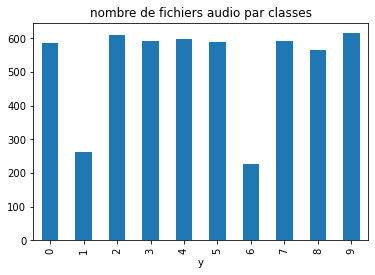

In [26]:
y_train.groupby(y_train).size().plot.bar(title="nombre de fichiers audio par classes")

<AxesSubplot:title={'center':'nombre de fichiers audio par classes'}, xlabel='y'>

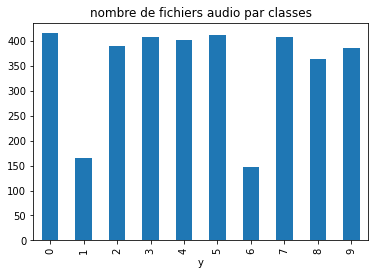

In [27]:
y_test.groupby(y_test).size().plot.bar(title="nombre de fichiers audio par classes")

# Modèle d'apprentissage

## Keras - Deep learning

In [28]:
model = keras.Sequential([
  keras.layers.Dense(256, input_dim=40, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(5e-05)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(nb_labels, activation='softmax'),
  ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                metrics=['accuracy', 
                keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2'),
                keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3')])
# 'accuracy' équivalent à 'sparse_categorical_accuracy'

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

In [29]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, verbose=1)

Train on 5239 samples, validate on 3493 samples
Epoch 1/100
5239/5239 [==============================] - 1s 211us/sample - loss: 5.3217 - accuracy: 0.1857 - top2: 0.3176 - top3: 0.4362 - val_loss: 2.1481 - val_accuracy: 0.2184 - val_top2: 0.4040 - val_top3: 0.5485
Epoch 2/100
5239/5239 [==============================] - 0s 77us/sample - loss: 2.2195 - accuracy: 0.2298 - top2: 0.3831 - top3: 0.5140 - val_loss: 1.9822 - val_accuracy: 0.3063 - val_top2: 0.4847 - val_top3: 0.6158
Epoch 3/100
5239/5239 [==============================] - 0s 78us/sample - loss: 1.9846 - accuracy: 0.2928 - top2: 0.4634 - top3: 0.6009 - val_loss: 1.7572 - val_accuracy: 0.4034 - val_top2: 0.5943 - val_top3: 0.7275
Epoch 4/100
5239/5239 [==============================] - 0s 82us/sample - loss: 1.8495 - accuracy: 0.3514 - top2: 0.5289 - top3: 0.6589 - val_loss: 1.6064 - val_accuracy: 0.4752 - val_top2: 0.6516 - val_top3: 0.7615
Epoch 5/100
5239/5239 [==============================] - 0s 83us/sample - loss: 1.7149 

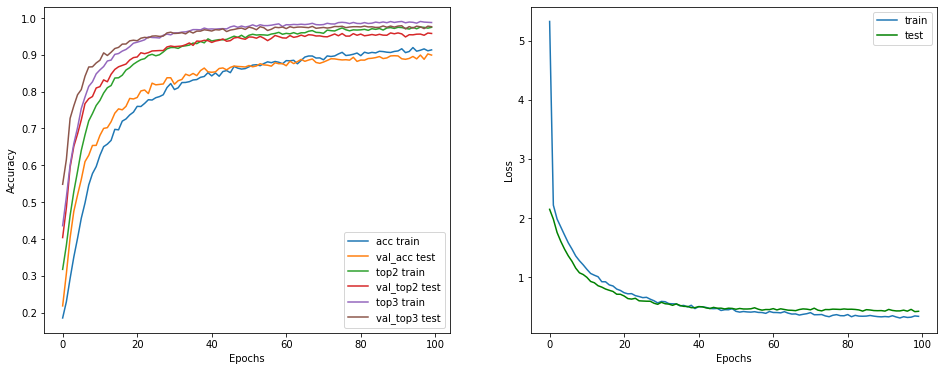

In [30]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.plot(history.history['accuracy'], label='acc train')
plt.plot(history.history['val_accuracy'], label='val_acc test')
plt.plot(history.history['top2'], label='top2 train')
plt.plot(history.history['val_top2'], label='val_top2 test')
plt.plot(history.history['top3'], label='top3 train')
plt.plot(history.history['val_top3'], label='val_top3 test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label ='test', color='g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [31]:
#Sauvegarde du modèle
model.save("../model/urbansound8k.h5")

## Test de la prédiction

In [32]:
model = keras.models.load_model("../model/urbansound8k.h5")

In [33]:
test_sound = test_file_name[0]
test_sound

'101415-3-0-2.wav'

In [34]:
test_sound_path = [*Path('../data').rglob(test_sound)][0]
test_sound_path

WindowsPath('../data/urbansound8k/fold1/101415-3-0-2.wav')

In [35]:
test_sound_features = extract_features(test_sound_path)
test_sound_features

array([-4.0396762e+02,  9.4398071e+01,  1.7751820e+01, -1.1521064e+01,
       -7.4892626e+00,  4.0730672e+00, -1.6308868e+01, -6.7353740e+00,
       -1.0601528e+01, -5.1134138e+00,  7.2173916e-02, -4.9856830e+00,
        1.0708647e+00,  1.1721996e+00,  5.8166325e-01,  5.8854532e+00,
        3.1696415e+00,  3.1821740e+00, -4.0253158e+00, -3.9655960e+00,
       -1.6780925e+00, -3.3084381e+00, -3.3129520e+00, -5.8684025e+00,
       -1.6284789e+00, -2.5598698e+00, -2.6984303e+00, -5.4842159e-02,
       -5.5218452e-01, -1.7920844e-01, -8.3389997e-01, -1.0343000e+00,
       -2.6558142e+00, -5.2379251e-01, -2.0024073e+00, -2.9415321e+00,
       -3.1495199e+00, -1.4475015e+00, -2.5126765e+00, -2.7958148e+00],
      dtype=float32)

In [36]:
test_sound_features = test_sound_features.reshape(1, 40)
test_sound_features.shape

(1, 40)

In [37]:
prediction = model.predict(test_sound_features)[0]
prediction

array([7.6740668e-15, 2.0205730e-16, 5.0834499e-13, 9.9997056e-01,
       6.5932766e-11, 1.1836960e-14, 2.9390751e-05, 1.4153910e-22,
       2.9641058e-08, 7.9762303e-09], dtype=float32)

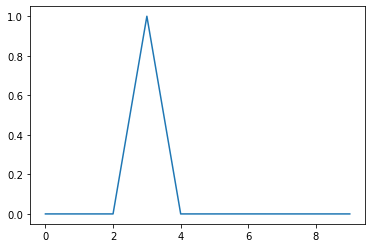

In [38]:
plt.plot(prediction) 

In [39]:
labels_class = labels.reset_index()
labels_class.loc[labels_class['slice_file_name']=='100032-3-0-0.wav']

,slice_file_name,class
0,100032-3-0-0.wav,dog_bark


In [40]:
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

In [41]:
predicted_classe_index = np.argmax(prediction)
predicted_classe_index

3

In [42]:
predicted_classe = classes[predicted_classe_index]
predicted_classe

'dog_bark'

In [43]:
print(f'La prédiction de la classe pour le fichier {test_sound} est : {predicted_classe} avec {prediction[predicted_classe_index]*100}% de précision.')

La prédiction de la classe pour le fichier 101415-3-0-2.wav est : dog_bark avec 99.9970555305481% de précision.
